In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import os,sys
sys.path.append('/home/sjxue/code/dense_correspondence/dataset')

In [3]:
from spartan_dataset_masked import SpartanDataset
import dense_correspondence_manipulation.utils.utils as utils

utils.add_dense_correspondence_to_python_path()
import dense_correspondence.correspondence_tools.correspondence_finder as correspondence_finder
import dense_correspondence.correspondence_tools.correspondence_plotter as correspondence_plotter
from dense_correspondence.dataset.dense_correspondence_dataset_masked import ImageType

import os
import torch
import numpy as np
%matplotlib inline

dataset_config_filename = os.path.join(utils.getDenseCorrespondenceSourceDir(), 'config', 'dense_correspondence',
                                       'dataset', 'composite',
                                       'caterpillar_upright.yaml')

dataset_config = utils.getDictFromYamlFilename(dataset_config_filename)

dataset = SpartanDataset(debug=True, config=dataset_config)

Using SpartanDataset:
   - in train mode
   - number of scenes 11
   - total images:     2851


In [9]:
dataset.get_random_scene_name()

'2018-04-10-16-08-46'

In [33]:
dataset.get_pose_data('2018-04-10-16-12-21')

{0: {'camera_to_world': {'quaternion': {'w': 0.11951640191504183,
    'x': -0.7072629208126248,
    'y': 0.6764667158389606,
    'z': -0.16699632594440006},
   'translation': {'x': 0.2974715001637026,
    'y': -0.00824797614277843,
    'z': 0.8272225438962857}},
  'depth_image_filename': '000000_depth.png',
  'rgb_image_filename': '000000_rgb.png',
  'timestamp': 1523376744633972876},
 47: {'camera_to_world': {'quaternion': {'w': 0.13153520488801787,
    'x': -0.7054212721094913,
    'y': 0.6738656935924062,
    'z': -0.17602370786266244},
   'translation': {'x': 0.30980587901924084,
    'y': -0.011578744465936134,
    'z': 0.8000610710627433}},
  'depth_image_filename': '000047_depth.png',
  'rgb_image_filename': '000047_rgb.png',
  'timestamp': 1523376746202207796},
 54: {'camera_to_world': {'quaternion': {'w': 0.14379529893010992,
    'x': -0.7025885468874516,
    'y': 0.6719894284212944,
    'z': -0.1847226404050188},
   'translation': {'x': 0.3202935889487728,
    'y': -0.01516829

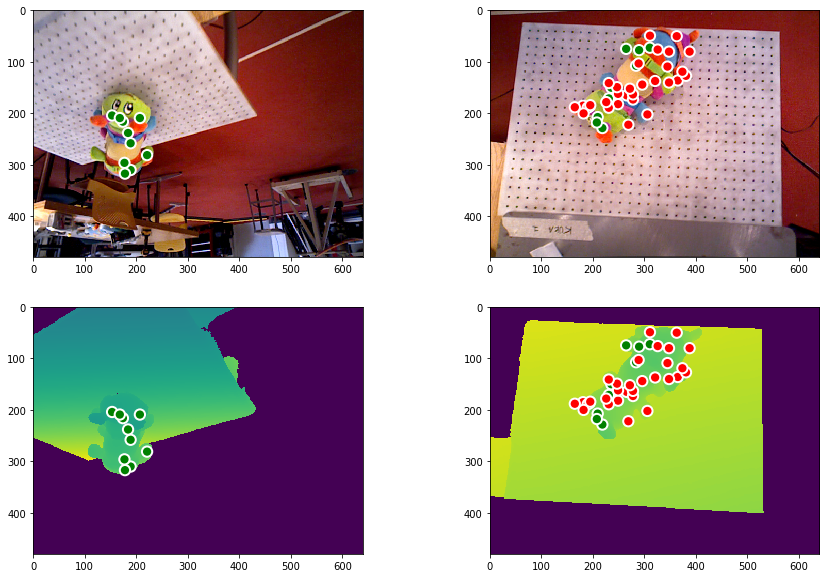

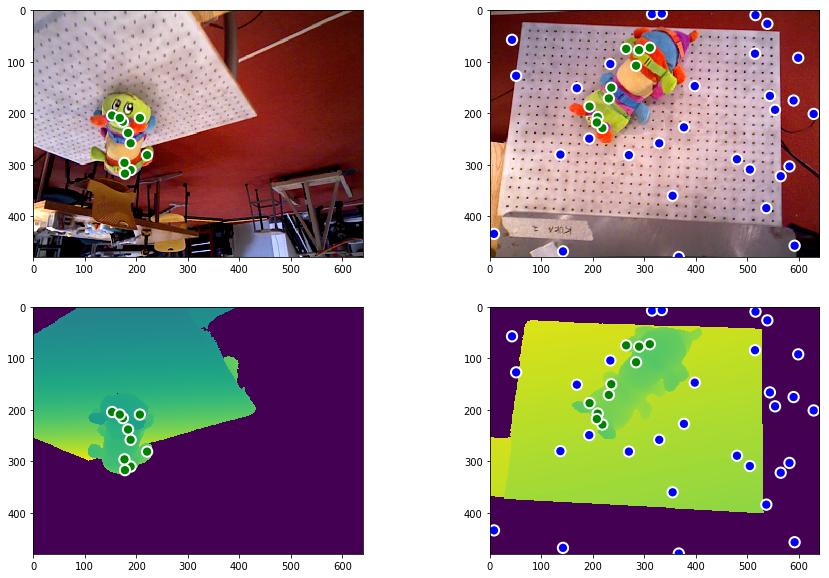

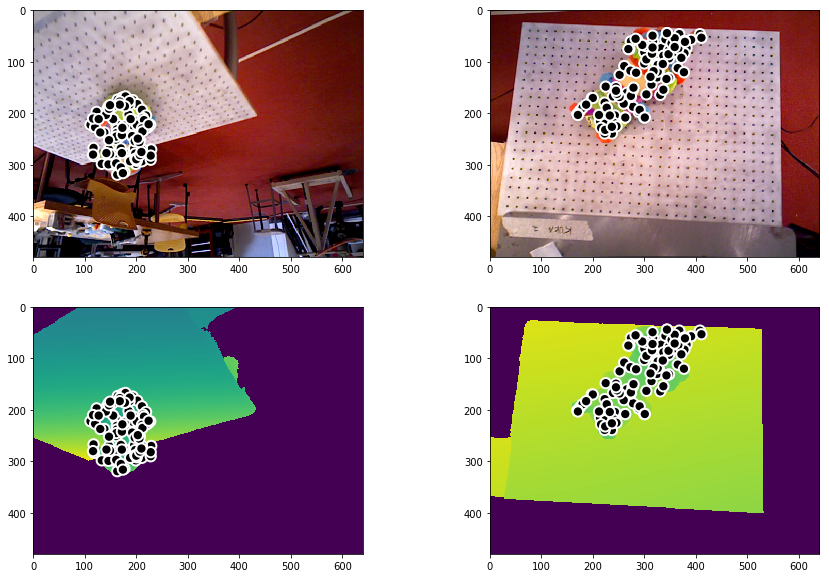

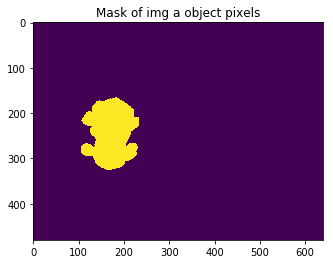

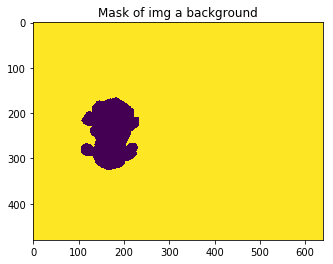

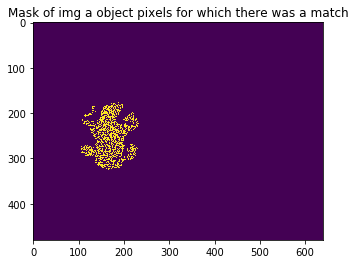

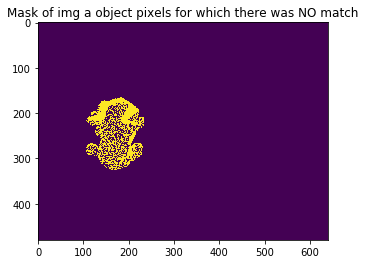

In [10]:
data = dataset.get_single_object_within_scene_data()
match_type, image_a_rgb, image_b_rgb, \
matches_a, matches_b, masked_non_matches_a, \
masked_non_matches_a, non_masked_non_matches_a, \
non_masked_non_matches_b, blind_non_matches_a, \
blind_non_matches_b, metadata = data

In [11]:
def get_relative_pose(dataset,metadata):
    X_OCa = dataset.get_pose_from_scene_name_and_idx(metadata['scene_name'], metadata['image_a_idx'])
    X_OCb = dataset.get_pose_from_scene_name_and_idx(metadata['scene_name'], metadata['image_b_idx'])
    X_CaCb = np.matmul(np.linalg.inv(X_OCa), X_OCb)
    return X_CaCb

In [12]:
get_relative_pose(dataset, metadata)

array([[ 0.85795084,  0.50951769, -0.0656664 ,  0.37923603],
       [-0.24252207,  0.51438092,  0.82255414, -0.55744967],
       [ 0.45288342, -0.68978547,  0.56488283,  0.33789696],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [12]:
metadata

{'image_a_idx': 674,
 'image_b_idx': 1304,
 'object_id': 'caterpillar',
 'object_id_int': 0,
 'scene_name': '2018-04-10-16-06-26',
 'type': 0}

In [23]:
dataset.get_pose_from_scene_name_and_idx('2018-04-10-16-06-26',674)

array([[-0.18918481, -0.62384167,  0.75830777,  0.15626   ],
       [-0.94549155,  0.32418532,  0.03081555,  0.31088152],
       [-0.26505627, -0.71114376, -0.65116797,  0.70365321],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [16]:
test(dataset,2)

caterpillar


In [21]:
dataset.test = test

In [22]:
dataset.test(1)

TypeError: test() takes exactly 2 arguments (1 given)

In [13]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from torchvision import transforms
# from Ipython.display import

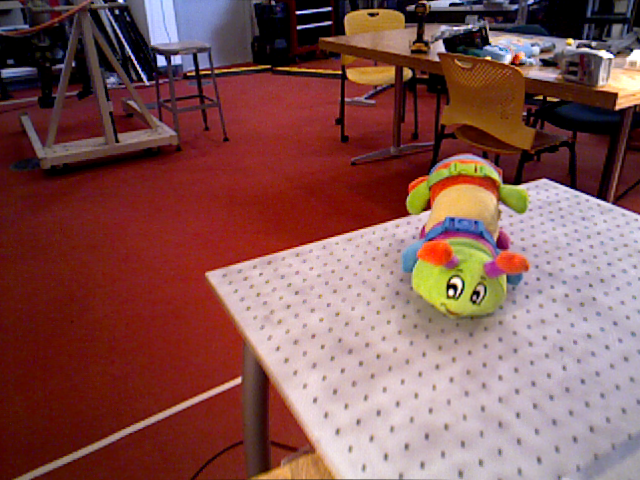

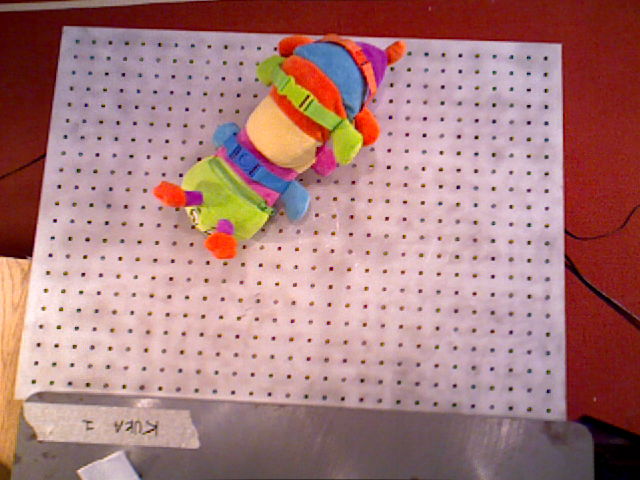

In [14]:
img_filename = dataset.get_image_filename(metadata['scene_name'], metadata['image_a_idx'], 0)
image_a = dataset.get_rgb_image(img_filename)
img_filename = dataset.get_image_filename(metadata['scene_name'], metadata['image_b_idx'], 0)
image_b = dataset.get_rgb_image(img_filename)
display(image_a)
display(image_b)

In [28]:
MIN_MATCH_COUNT = 10

img1 = np.array(image_a)          # queryImage
img2 = np.array(image_b) # trainImage

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)


In [29]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print "Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT)
    matchesMask = None

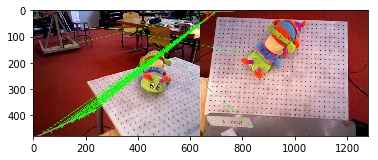

In [30]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3)

In [32]:
metadata

{'image_a_idx': 974,
 'image_b_idx': 1291,
 'object_id': 'caterpillar',
 'object_id_int': 0,
 'scene_name': '2018-04-10-16-16-15',
 'type': 0}